# TODO:

* Use whole episode as batch when learning?
* Try without gradient clipping

In [ ]:
import sys
sys.path.append("..")
import models
import policy_gradient_methods
import utils
import gymnasium as gym
import torch
import random

# Settings

In [3]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_EPISODES = 100
GRAD_CLIP_VALUE = 100
GAMMA = 0.9
NN_HIDDEN_LAYER_SIZES = [8, 4]
RNG_SEED = 7
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("PyTorch device:", device)
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)

PyTorch device: cpu


# REINFORCE

## Linear model

In [ ]:
def select_action_softmax(model, state):
    with torch.no_grad():
        return torch.distributions.categorical.Categorical(model(state)).sample().item()

def train_episodic_reinforce(env, policy_model, loss_func, optimizer, device, rng_seed, num_episodes, gamma, grad_clip_value=None):
    returns = []
    for episode in range(num_episodes):
        # Initiate episode
        # Set seed only one time per training run. For more info, see https://gymnasium.farama.org/api/env/.
        seed = rng_seed if episode == 0 else None
        observation, info = env.reset(seed=seed)
        state = torch.tensor(observation, device=device)
        truncated = False
        terminated = False
        G = 0
        states = [state]
        actions = []
        rewards = []

        # Generate episode
        while not (terminated or truncated) and G < 4: # TODO: REMEMBER TO REMOVE!!!!!!!!!!!!!!!!
            action = select_action_softmax(policy_model, state)
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = torch.tensor(observation, device=device)
            states.append(next_state)
            actions.append(action)
            rewards.append(reward)
            G += reward
            state = next_state
        returns.append(G)

        # Learn from episode
        G = 0
        for t in reversed(range(len(rewards))):
            G = gamma * G + rewards[t]
            print(t, G, gamma**t)
            print("states[t]:",states[t])
            print("actions[t]:", actions[t])
            print(policy_model(states[t]))
            print(policy_model(states[t])[actions[t]])
            print(".................")
            loss = -gamma**t * G * torch.log(policy_model(states[t])[actions[t]])
            optimizer.zero_grad()
            loss.backward()
            if grad_clip_value != None:
                torch.nn.utils.clip_grad_value_(policy_model.parameters(), grad_clip_value)
            optimizer.step()
        
    return returns, states, actions, rewards

In [ ]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], env.action_space.n).to(device),
    torch.nn.Softmax(dim=0)
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
observation, info = env.reset(seed=RNG_SEED)
state = torch.tensor(observation, device=device)
action = select_action_softmax(model, state)
with torch.no_grad():
    print(model(state))
print(action)
print("--------------------")
returns, states, actions, rewards = train_episodic_reinforce(
    env, model, loss_func, optimizer, device, RNG_SEED, 1, GAMMA, GRAD_CLIP_VALUE
)
print("--------------------")
print("returns:", returns)
print("states:", states)
print(len(states))
print("actions:", actions)
print(len(actions))
print("rewards:", rewards)
print(len(rewards))
env.close()
#utils.plot_returns(returns)

In [4]:
def select_action_softmax(model, state):
    with torch.no_grad():
        return torch.distributions.categorical.Categorical(model(state)).sample().item()

def train_episodic_reinforce(env, policy_model, optimizer, device, rng_seed, num_episodes, gamma, grad_clip_value=None):
    returns = []
    for episode in range(num_episodes):
        # Initiate episode
        # Set seed only one time per training run. For more info, see https://gymnasium.farama.org/api/env/.
        seed = rng_seed if episode == 0 else None
        observation, info = env.reset(seed=seed)
        state = torch.tensor(observation, device=device)
        truncated = False
        terminated = False
        G = 0
        states = [state]
        actions = []
        rewards = []

        # Generate episode
        while not (terminated or truncated):
            action = select_action_softmax(policy_model, state)
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = torch.tensor(observation, device=device)
            states.append(next_state)
            actions.append(action)
            rewards.append(reward)
            G += reward
            state = next_state
        returns.append(G)

        # Learn from episode
        G = 0
        for t in reversed(range(len(rewards))):
            G = gamma * G + rewards[t]
            loss = -gamma**t * G * torch.log(policy_model(states[t])[actions[t]])
            optimizer.zero_grad()
            loss.backward()
            if grad_clip_value != None:
                torch.nn.utils.clip_grad_value_(policy_model.parameters(), grad_clip_value)
            optimizer.step()
        
    return returns, states, actions, rewards

Average return per episode: 36.52


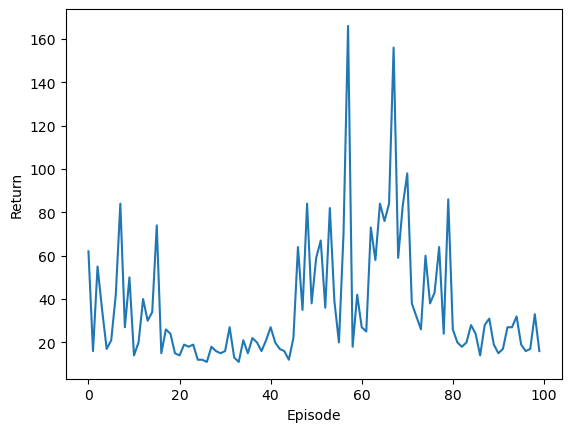

In [8]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], env.action_space.n).to(device),
    torch.nn.Softmax(dim=0)
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
returns, states, actions, rewards = train_episodic_reinforce(
    env, model, optimizer, device, RNG_SEED, NUM_EPISODES, GAMMA, GRAD_CLIP_VALUE
)
utils.plot_returns(returns)

## Neural network model

# REINFORCE with baseline

## Linear model

## Neural network model